### SCE Solar Disagg. Example Notebook
In this notebook, we use publicly available data and aggregated data from SCE circuits to show a sample implementation of solar disaggregation using the CSSS class developed by SLAC. 
The solar proxy used is obtained from a clearsky model using pvlib.
The temperature data is obtained from wunderground. 
There is no ground truth data so algorithm performance cannot be estimated. 
Furthermore, the solarproxy should be replaced with a monitored PV system within the area. 


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta,date
import requests
import pandas as pd
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import io
import csss as CSSS


def createDateTime(row):
    row['datetime']=row['record_date']+timedelta(hours=row['hour_id'])
    return row

def createTempInput(temp, size, minTemp=None, maxTemp=None):
    if (minTemp is None):
        minTemp=min(temp)
    if maxTemp is None:
        maxTemp=max(temp)
    minBound=int(np.floor(minTemp / size)) * size
    maxBound=int(np.floor(maxTemp / size)) * size + size
    rangeCount=int((maxBound-minBound) / size)
    result=[]
    for elem in temp:
        fullRanges = min( int(np.floor((elem-minBound) / size)), rangeCount-1)
        bound      = (minBound+fullRanges*size)
        lastRange  = elem-bound
        res        = [size for elem in range(fullRanges)]
        res.append(lastRange)
        for var in range(rangeCount-fullRanges-1):
            res.append(0)
        res.append(1)
        result.append(res)
    return minBound, maxBound,result


def getWeatherData(station, day, month, year):
    url = "http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={station}&day={day}&month={month}&year={year}&graphspan=day&format=1"
    full_url = url.format(station=station, day=day, month=month, year=year)
    print(full_url)
    # Request data from wunderground data
    response = requests.get(full_url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
    data = response.text
    # remove the excess <br> from the text data
    data = data.replace('<br>', '')
    # Convert to pandas dataframe (fails if issues with weather station)
    try:
        dataframe = pd.read_csv(io.StringIO(data), index_col=False)
        dataframe['station'] = station
    except Exception as e:
        print("Issue with date: {}-{}-{} for station {}".format(day,month,year, station))
        return None
    return dataframe
    


ImportError: No module named CSSS

### Get Weather Data for Santa Ana, CA 
We will use the temperature data to generate load regressors.

Working on KCAORANG51
http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID=KCAORANG51&day=2&month=6&year=2017&graphspan=day&format=1


Text(0,0.5,u'Temperature, [F]')

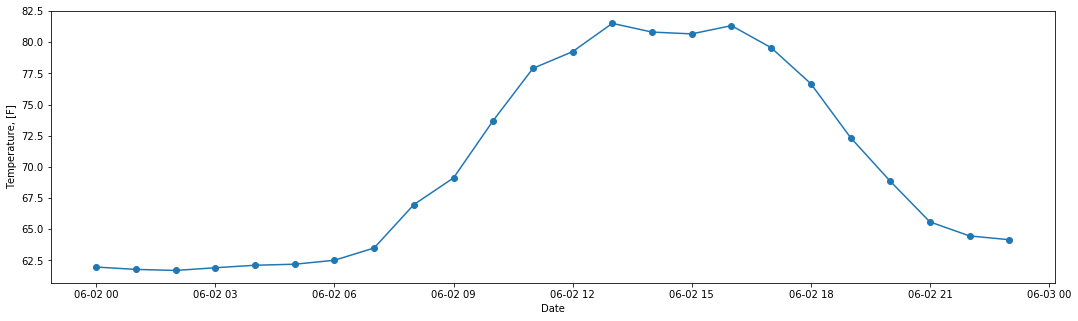

In [3]:
# Generate a list of all of the dates we want data for
start_date = "2017-06-02"
end_date = "2017-06-02"
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))
 
# Create a list of stations here to download data for
stations = [ 'KCAORANG51', ]
# Set a backoff time in seconds if a request fails
backoff_time = 10
data = {}
 
# Gather data for each station in turn and save to CSV.
for station in stations:
    print("Working on {}".format(station))
    data[station] = []
    for date in dates:
        # Print period statudatas update messages
        if date.day % 10 == 0:
            print("Working on date: {} for station {}".format(date, station))
        done = False
        while done == False:
            try:
                weather_data = getWeatherData(station, date.day, date.month, date.year)
                done = True
            except ConnectionError as e:
                # May get rate limited by Wunderground.com, backoff if so.
                print("Got connection error on {}".format(date))
                print("Will retry in {} seconds".format(backoff_time))
                time.sleep(10)
        # Add each processed date to the overall data
        data[station].append(weather_data)
    # Finally combine all of the individual days and output to CSV for analysis.
    weather_frame=pd.concat(data[station]).reset_index()
    weather_frame.to_csv("{}_weather.csv".format(station))

weather_frame['DateTime']=pd.to_datetime(weather_frame['Time'])
weather_frame.set_index('DateTime',inplace=True)
weather_frame.drop('Time',axis=1,inplace=True)
weather_frame.drop('index',axis=1,inplace=True)

if weather_frame.index[0].tz is None:
    weather_frame['DateTime']=weather_frame.index.tz_localize('US/Pacific')
    weather_frame.set_index('DateTime',inplace=True)
weather_frame=weather_frame.resample('1H').mean()

## PLOT TEMPERATURE DATA
plt.figure(figsize=[18,5])
plt.plot(weather_frame.index, weather_frame['TemperatureF'],'-o')
plt.xlabel('Date')
plt.ylabel('Temperature, [F]')

### Let's get data from SCE aggregated AMI data
We will use alluminum, customer ID = 5518257 as an example

In [4]:
frame=pd.read_csv('SCE/sce_cooked_ami.csv',parse_dates=['record_date'])
aluminum=frame[frame['circuit_name']=='ALUMINUM']

### Let's look at average load profiles accross aluminum
means=aluminum.groupby(['customer_id','hour_id'],as_index=False)['energy_value'].mean()
plt.figure(figsize=[18,5])
for elem in means.groupby(['customer_id'],as_index=False):
    plt.plot(elem[1]['hour_id'],elem[1]['energy_value'],'-o',label=elem[0],)
plt.xlabel('Hour_id')
plt.title('Average Customer Load Profiles')
plt.ylabel('Ave. energy [kWh]')

IOError: File SCE/sce_cooked_ami.csv does not exist

In [ ]:
sample_customer=aluminum[aluminum['customer_id']=="5518257"]
date_customer=sample_customer[(sample_customer['record_date']<datetime(2017,6,3)) & (sample_customer['record_date']>datetime(2017,6,1))]
date_customer=date_customer.apply(lambda row: createDateTime(row),axis=1)
date_customer['datetime'] = pd.to_datetime(date_customer['datetime'],unit='ns')
date_customer=date_customer[['datetime','energy_value']]
date_customer.set_index('datetime', inplace=True)
date_customer['datetime']=date_customer.index.tz_localize('US/Pacific')
date_customer.set_index('datetime', inplace=True)


In [ ]:
plt.figure(figsize=[18,5])
plt.plot(date_customer.index,date_customer['energy_value'])
plt.xlabel('Hour')
plt.ylabel('Energy, [kWh]')


In [ ]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

tus = Location(33.745, -117.8677, 'US/Pacific', 700, 'Santa Ana')

times = pd.DatetimeIndex(date_customer.index)
#times=times.tz_localize('US/Pacific')
cs = tus.get_clearsky(times)  # ineichen with climatology table by default

plt.figure(figsize=[18,5])
plt.plot(cs.index,cs['ghi'],'-o',label='ghi')
plt.ylabel('Irradiance $W/m^2$');

plt.title('Ineichen, climatological turbidity');



### Merge aggregate load, weather and irradiance data together on index

In [ ]:
date_customer['datetime']=date_customer.index.tz_localize(None)
weather_frame['datetime']=weather_frame.index.tz_localize(None)
cs['datetime']=cs.index.tz_localize(None)
data=pd.merge(date_customer[['datetime','energy_value']], weather_frame[['datetime','TemperatureF']], on='datetime')
data=pd.merge(data, cs[['datetime','ghi']],on='datetime')
data.set_index('datetime',inplace=True)
data.plot(figsize=[18,5])

In [ ]:
customerids=["5518257"]
## Get HOD regressors
hod = pd.Series([t.hour for t in data.index])
hod = pd.get_dummies(hod)

## Get temperature regressors
Tmin, Tmax, tempregress = regressor=createTempInput(data['TemperatureF'], 10)

loadregressors = np.hstack([hod,tempregress])
netload = np.array(data['energy_value'])
solarproxy = np.array(data['ghi'])
names = ['solar_%s' % d for d in customerids]

# Try it out. 
CSSEtry = CSSS.CSSS(netload)  ## Instantiate model with aggregate signal, Y
CSSEtry.addSource(loadregressors, alpha = 10, name = 'Load')  ## Add a model for Y1
CSSEtry.addSource(solarproxy, alpha = 1, name = 'Solar')  ## Add a model for Y2
1000
CSSEtry.addConstraint(CSSEtry.models['Solar']['source'] < 0 )
CSSEtry.addConstraint(CSSEtry.models['Load']['source'] > 0 )


start=time.time()
CSSEtry.constructSolve()
plt.figure(figsize=[18,5])

plt.plot(CSSEtry.models['Load']['source'].value, label = 'Dis. Load')

#plt.plot(CSSEtry.models['Y1']['regressor'] * CSSEtry.models['Y1']['theta'].value, label = 'Modeled')
plt.plot(CSSEtry.models['Solar']['source'].value, label = 'Dis. Solar')

plt.legend()
plt.show()